In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

from utils import filt_decompose

In [62]:
def process_ubar_site(ds_, t1, t2):
    ds = ds_.sel(time=slice(t1,t2))
    
    #print(ds)
    ubar = ds['u'].mean(axis=0)
    vbar = ds['v'].mean(axis=0)

    t = ubar.time
    dt_ = t[1] - t[0]
    dt = dt_.values.astype(float)/1e9
    
    ubar_qc = ubar.where(~np.isnan(ubar), 0)
    vbar_qc = vbar.where(~np.isnan(vbar), 0)
    
    uf = filt_decompose(ubar_qc.values, dt)
    vf = filt_decompose(vbar_qc.values, dt)
    
    da_ulow = xr.DataArray(uf[:,0], coords={'time':t},
                         attrs={'long_name':'sub-tidal barotropic u velocity', 'units':'m s-1'})
    da_vlow = xr.DataArray(vf[:,0], coords={'time':t},
                         attrs={'long_name':'sub-tidal barotropic v velocity', 'units':'m s-1'})
    
    da_ut = xr.DataArray(uf[:,1], coords={'time':t},
                         attrs={'long_name':'tidal barotropic u velocity', 'units':'m s-1'})
    da_vt = xr.DataArray(vf[:,1], coords={'time':t},
                         attrs={'long_name':'tidal barotropic v velocity', 'units':'m s-1'})
    
    ds_out = xr.Dataset({'ubar_low':da_ulow,
                         'vbar_low':da_vlow,
                         'ubar_tide':da_ut,
                         'vbar_tide':da_vt,
                         'latitude':ds['lat_nom'],
                         'longitude':ds['lon_nom'],
                        })
    return ds_out

In [63]:
t1 = '2023-04-22 00:00:00'
t2 = '2023-05-31 23:59:00'

In [64]:

basedir = '/home/jupyter-mrayson/data/SWOT_Cruise/FV02/stacked_moorings_adcp'
ncfiles = [
    f'{basedir}/[BB23]_[BB23_REC]_[S245]_[5]_[Quartermaster]_[11795]_[no_outfile_append].nc',
    f'{basedir}/[BB23]_[BB23_REC]_[W310]_[multi(2)_nominal_instrument_height_asb]_[multi(2)_instrument_model]_[multi(2)_instrument_serial_number]_[no_outfile_append].nc',
    f'{basedir}/[BB23]_[BB23_REC]_[N280]_[5]_[Longranger]_[24613]_[no_outfile_append].nc',
]

H = np.array([254., 313., 280.])

ds_ = [process_ubar_site(xr.open_dataset(ff), t1, t2) for ff in ncfiles]
ds_[2]
#ds = ds_.sel(tim(e=slice(t1,t2))
#ds

<xarray.Dataset>
Dimensions:    (time: 57600)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-22 ... 2023-05-31T23:59:00
    lat_nom    float64 -14.05
    lon_nom    float64 123.0
    z_nom      <U1 ''
Data variables:
    ubar_low   (time) float64 0.001771 0.001699 0.001627 ... 0.1198 0.1198
    vbar_low   (time) float64 -0.09712 -0.09708 -0.09705 ... 0.02194 0.02194
    ubar_tide  (time) float64 0.1693 0.1707 0.172 ... -1.745e-09 -1.476e-09
    vbar_tide  (time) float64 -0.1167 -0.1175 -0.1183 ... 1.361e-09 1.151e-09
    latitude   float64 -14.05
    longitude  float64 123.0

In [65]:
ds_i = [ds_[0]]
ds_i.append(ds_[1].interp(time=ds_[0].time))
ds_i.append(ds_[2].interp(time=ds_[0].time))
ds = xr.concat(ds_i, dim='site')
ds

<xarray.Dataset>
Dimensions:    (time: 57600, site: 3)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-22T00:00:00.809999942 ... 2023-0...
    lat_nom    (site) float64 -14.23 -14.14 -14.05
    lon_nom    (site) float64 123.0 122.8 123.0
    z_nom      <U1 ''
Dimensions without coordinates: site
Data variables:
    ubar_low   (site, time) float64 -0.0003002 -0.0002991 ... 0.1198 0.1198
    vbar_low   (site, time) float64 0.000427 0.0004271 ... 0.02194 0.02194
    ubar_tide  (site, time) float64 0.0004244 0.0004228 ... -1.477e-09
    vbar_tide  (site, time) float64 -0.0005546 -0.0005547 ... 1.152e-09
    latitude   (site) float64 -14.23 -14.14 -14.05
    longitude  (site) float64 123.0 122.8 123.0

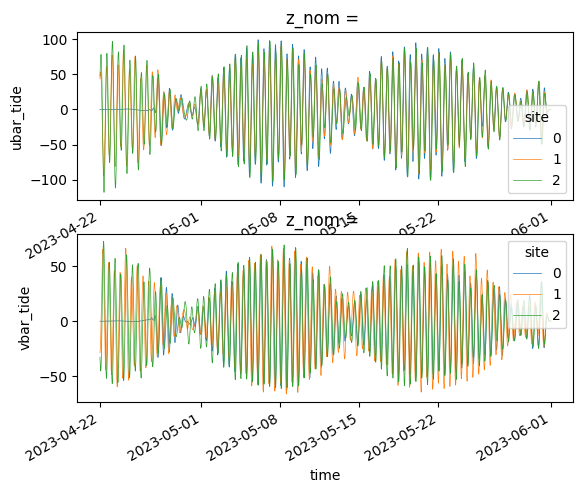

In [66]:
ax=plt.subplot(211)
(ds['ubar_tide']*H[:,None]).plot.line(x='time', lw=0.5)
ax=plt.subplot(212)
(ds['vbar_tide']*H[:,None]).plot.line(x='time', lw=0.5)

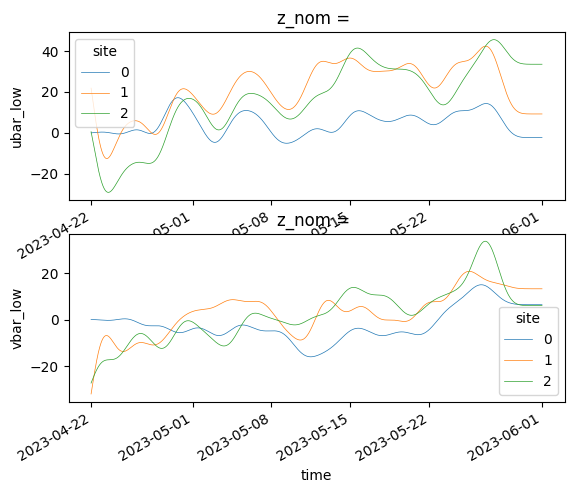

In [67]:
ax=plt.subplot(211)
(ds['ubar_low']*H[:,None]).plot.line(x='time', lw=0.5)
ax=plt.subplot(212)
(ds['vbar_low']*H[:,None]).plot.line(x='time', lw=0.5)

(57600,) (57600, 3)
(57600,) (57600, 3)
(57600,) (57600, 3)
(57600,) (57600, 3)


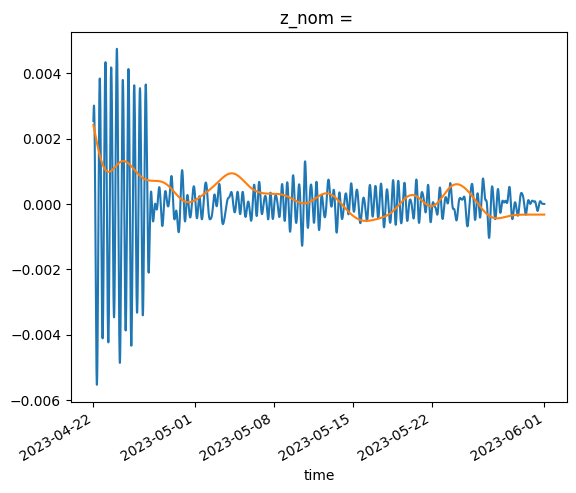

In [73]:
def gradplane(xA, xB, xC, yA, yB, yC, zA, zB, zC):

    ABx = xB - xA
    ABy = yB - yA
    ABz = zB - zA
    
    ACx = xC - xA
    ACy = yC - yA
    ACz = zC - zA
    
    mx = ABy*ACz - ABz*ACy
    my = ABz*ACx - ABx*ACz
    mz = ABx*ACy - ACx*ABy
    
    return -mx/mz, -my/mz

def grad(x, y, z):
    ones = np.ones(z.shape[0])
    print(ones.shape, z.shape)

    dz_dx, dz_dy = gradplane(x[0]*ones, x[1]*ones, x[2]*ones, 
            y[0]*ones, y[1]*ones, y[2]*ones,
            z[:,0], z[:,1], z[:,2])
    
    return dz_dx, dz_dy
    
# In[132]:

# Need to convert lat/lon into Easting/Northing
from sfoda.utils.myproj import MyProj

P = MyProj(None, utmzone=51, isnorth=False)

x, y = P.to_xy(ds.longitude, ds.latitude)
x,y


H = np.array([254., 313., 280.])
# H = np.array([254., 313., 280.])

dut_dx, dut_dy = grad(x,y,(ds['ubar_tide']*H[:,None]).T)
dvt_dx, dvt_dy = grad(x,y,(ds['vbar_tide']*H[:,None]).T)

deta_dt = -(dut_dx + dvt_dy)

dut_dx, dut_dy = grad(x,y,(ds['ubar_low']*H[:,None]).T)
dvt_dx, dvt_dy = grad(x,y,(ds['vbar_low']*H[:,None]).T)

detalow_dt = -(dut_dx + dvt_dy)

deta_dt.plot()
detalow_dt.plot()

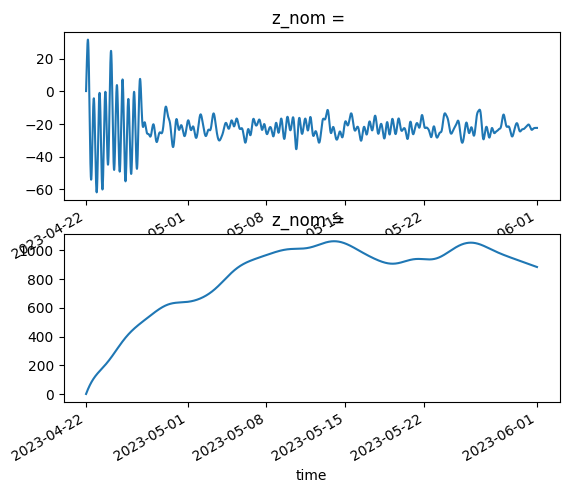

In [74]:
ax=plt.subplot(211)
np.cumsum(deta_dt*60.).plot()
ax=plt.subplot(212)
np.cumsum(detalow_dt*60.).plot()

---
# Testing below here...

In [23]:
ubar = ds['u'].mean(axis=0)
vbar = ds['v'].mean(axis=0)

In [26]:
t = ubar.time
dt_ = t[1] - t[0]
dt = dt_.values.astype(float)/1e9
dt

60.0

In [32]:
ubar_qc = ubar.where(~np.isnan(ubar), 0)
vbar_qc = ubar.where(~np.isnan(vbar), 0)

uf = filt_decompose(ubar_qc.values, dt)
vf = filt_decompose(vbar_qc.values, dt)


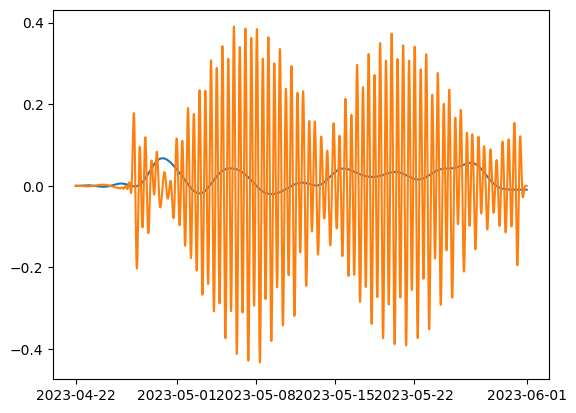

In [33]:
plt.plot(t, uf[:,0])
plt.plot(t, uf[:,1])

In [36]:
da_ulow = xr.DataArray(uf[:,0], coords={'time':t},
                     attrs={'long_name':'sub-tidal barotropic u velocity', 'units':'m s-1'})
da_vlow = xr.DataArray(vf[:,0], coords={'time':t},
                     attrs={'long_name':'sub-tidal barotropic v velocity', 'units':'m s-1'})

da_ut = xr.DataArray(uf[:,1], coords={'time':t},
                     attrs={'long_name':'tidal barotropic u velocity', 'units':'m s-1'})
da_vt = xr.DataArray(vf[:,1], coords={'time':t},
                     attrs={'long_name':'tidal barotropic v velocity', 'units':'m s-1'})

ds_out = xr.Dataset({'ubar_low':da_ulow,
                     'vbar_low':da_vlow,
                     'da_utide':da_ut,
                     'da_vtide':da_vt,
                     'latitude':ds['lat_nom'],
                     'longitude':ds['lon_nom'],
                    })
ds_out

<xarray.Dataset>
Dimensions:   (time: 57600)
Coordinates:
  * time      (time) datetime64[ns] 2023-04-22T00:00:00.809999942 ... 2023-05...
Data variables:
    ubar_low  (time) float64 -0.0003002 -0.0002991 ... -0.00948 -0.00948
    vbar_low  (time) float64 -0.0003002 -0.0002991 ... -0.00948 -0.00948
    da_utide  (time) float64 0.0004244 0.0004228 ... -2.384e-09 -2.016e-09
    da_vtide  (time) float64 0.0004244 0.0004228 ... -2.384e-09 -2.016e-09